In [ ]:
import torch

def format_pytorch_version(version):
    return version.split('+')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
ERROR: Invalid requirement: 'cu124]+cu124.html': Expected end or semicolon (after name and no valid version specifier)
    cu124]+cu124.html
         ^
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime, timedelta
import heapq
from scipy.optimize import curve_fit
import warnings
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

# 필요한 라이브러리 설치
try:
    import torch_geometric
except ImportError:
    print("Installing required packages...")
    !pip install torch-geometric
    !pip install yfinance
    !pip install networkx
    !pip install scipy
    !pip install scikit-learn
    !pip install matplotlib

print("주식 리밸런싱 모델 구현 시작")

주식 리밸런싱 모델 구현 시작


In [ ]:
#1 데이터 수집 및 전처리

In [ ]:
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.returns = None
        self.features = None
        self.adjacency_matrix = None

    def fetch_data(self):
        """Yahoo Finance에서 주식 데이터 가져오기"""
        print("주식 데이터 가져오는 중...")
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date, auto_adjust=False)
        self.data = self.data['Adj Close']

        # 결측치 처리
        self.data = self.data.fillna(method='ffill')

        # 수익률 계산
        self.returns = self.data.pct_change().dropna()

        return self.data

    def calculate_five_factors(self):
        """5-Factor 모델 기반 특성 계산"""
        print("5-Factor 모델 특성 계산 중...")

        # 시장 요인 (Market Factor) - 전체 시장 수익률
        market_return = self.returns.mean(axis=1)

        features = []

        for ticker in self.tickers:
            # 개별 주식 데이터
            stock_data = yf.Ticker(ticker)

            # 기본 정보
            info = stock_data.info

            # 1. 시장 요인 (Market Beta)
            beta = np.cov(self.returns[ticker], market_return)[0, 1] / np.var(market_return)

            # 2. 규모 요인 (Size Factor) - 시가총액
            try:
                market_cap = info.get('marketCap', 0)
                if market_cap == 0:
                    market_cap = self.data[ticker].iloc[-1] * info.get('sharesOutstanding', 1000000)
            except:
                market_cap = 1000000  # 기본값

            # 3. 가치 요인 (Value Factor) - P/B 비율의 역수
            try:
                pb_ratio = info.get('priceToBook', 2)
                value_factor = 1 / pb_ratio if pb_ratio > 0 else 0.5
            except:
                value_factor = 0.5  # 기본값

            # 4. 수익성 요인 (Profitability) - ROE
            try:
                profitability = info.get('returnOnEquity', 0.1)
                if profitability is None:
                    profitability = 0.1
            except:
                profitability = 0.1  # 기본값

            # 5. 투자 요인 (Investment) - 자산 증가율
            try:
                investment = info.get('totalAssets', 0) / info.get('totalAssetsPrevYear', 1) - 1
                if investment is None or np.isnan(investment):
                    investment = 0.05
            except:
                investment = 0.05  # 기본값

            # 변동성 (추가 특성)
            volatility = self.returns[ticker].std()

            # 모멘텀 (추가 특성)
            momentum = self.returns[ticker].iloc[-20:].mean()

            features.append([
                beta,
                np.log(market_cap),
                value_factor,
                profitability,
                investment,
                volatility,
                momentum
            ])

        # 특성 정규화
        scaler = StandardScaler()
        self.features = scaler.fit_transform(features)

        return self.features

    def create_adjacency_matrix(self):
        """주식 간 상관관계 기반 인접 행렬 생성"""
        print("인접 행렬 생성 중...")

        # 상관관계 행렬 계산
        correlation_matrix = self.returns.corr().abs().values

        # 임계값 설정 (상관관계가 0.3 이상인 경우에만 연결)
        threshold = 0.3
        self.adjacency_matrix = (correlation_matrix > threshold).astype(float)

        # 자기 자신과의 연결 제거
        np.fill_diagonal(self.adjacency_matrix, 0)

        return self.adjacency_matrix

    def create_graph_data(self):
        """PyTorch Geometric 형식의 그래프 데이터 생성"""
        print("그래프 데이터 생성 중...")

        # 특성 및 인접 행렬이 없는 경우 계산
        if self.features is None:
            self.calculate_five_factors()
        if self.adjacency_matrix is None:
            self.create_adjacency_matrix()

        # 노드 특성
        x = torch.FloatTensor(self.features)

        # 엣지 인덱스 (인접 행렬에서 0이 아닌 요소의 인덱스)
        edge_indices = np.where(self.adjacency_matrix > 0)
        edge_index = torch.LongTensor(np.vstack(edge_indices))

        # 엣지 가중치 (상관관계 값)
        edge_attr = torch.FloatTensor(self.adjacency_matrix[edge_indices])

        # 그래프 데이터 생성
        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        return graph_data


In [ ]:
#2 gnn 모델

In [ ]:
class StockGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StockGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # 출력 차원을 입력 특성 차원과 동일하게 변경 (7)
        self.conv3 = GCNConv(hidden_dim, input_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_weight)

        return x

class GNNTrainer:
    def __init__(self, graph_data, input_dim, hidden_dim, output_dim, lr=0.01):
        self.graph_data = graph_data
        self.model = StockGNN(input_dim, hidden_dim, output_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.loss_history = []

    def train(self, epochs=100):
        """GNN 모델 학습"""
        print("GNN 모델 학습 중...")

        self.model.train()

        for epoch in range(epochs):
            self.optimizer.zero_grad()

            # 모델 예측
            embeddings = self.model(self.graph_data)

            # 손실 계산 (자기 재구성 손실)
            loss = self.criterion(embeddings, self.graph_data.x)
            self.loss_history.append(loss.item())

            # 역전파
            loss.backward()
            self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        # 학습 후 손실 시각화
        self.plot_loss()

        return self.model

    def plot_loss(self):
        """손실 함수 그래프 시각화"""
        plt.figure(figsize=(8, 5))
        plt.plot(self.loss_history, label='Training Loss', color='blue')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("GNN Training Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    def get_embeddings(self, visualize=True, tickers=None):
        """학습된 모델을 사용하여 임베딩 생성 + 시각화"""
        self.model.eval()
        with torch.no_grad():
            embeddings = self.model(self.graph_data).numpy()

        if visualize:
            self.visualize_embeddings(embeddings, tickers)

        return embeddings

    def visualize_embeddings(self, embeddings, tickers=None):
        """임베딩 2D 시각화 (t-SNE)"""
        n_samples = embeddings.shape[0]
        perplexity = min(5, n_samples - 1)  # ✅ 수정: t-SNE 오류 방지

        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        plt.figure(figsize=(8, 6))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='skyblue', edgecolor='k', s=70)

        if tickers:
            for i, ticker in enumerate(tickers):
                plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], ticker, fontsize=9)

        plt.title("t-SNE Visualization of Stock Embeddings")
        plt.grid(True)
        plt.show()


In [ ]:
# 7. 모델 실행 및 테스트

[*********************100%***********************]  10 of 10 completed

📦 [1] 데이터 수집 중...
주식 데이터 가져오는 중...
5-Factor 모델 특성 계산 중...


인접 행렬 생성 중...
그래프 데이터 생성 중...
✅ [1] 데이터 완료

🚀 [2] GNN 학습 시작
GNN 모델 학습 중...
Epoch 10/50, Loss: 0.6673
Epoch 20/50, Loss: 0.5849
Epoch 30/50, Loss: 0.5184
Epoch 40/50, Loss: 0.4915
Epoch 50/50, Loss: 0.5565


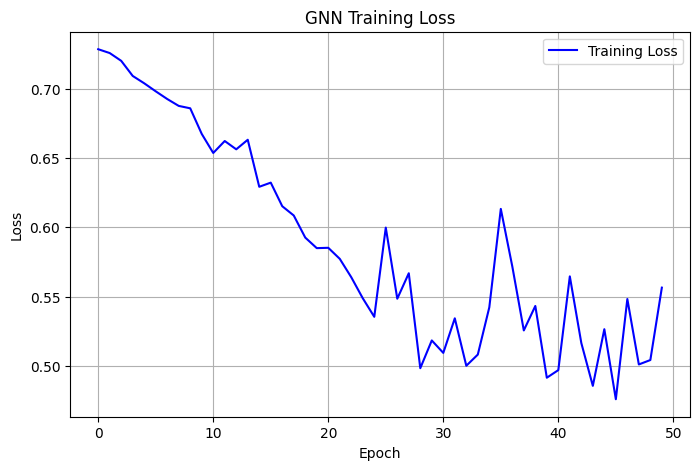


🎯 [3] GNN 임베딩 시각화


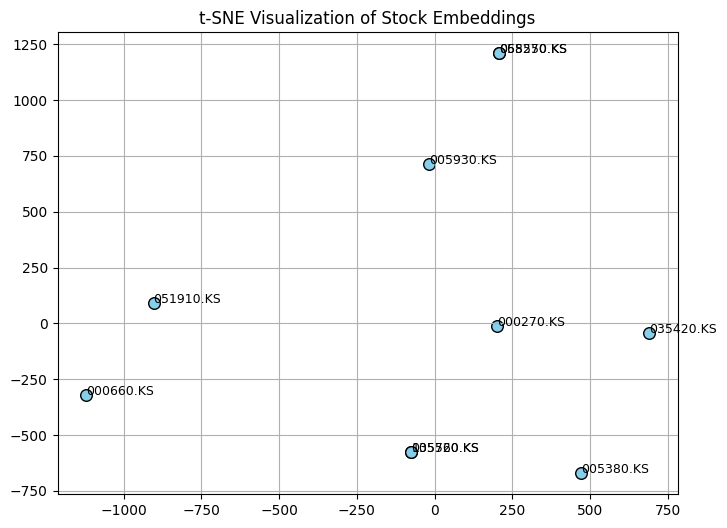

In [ ]:
from datetime import datetime, timedelta

# 1. 사용할 한국 주식 티커
tickers = ['005930.KS', '000660.KS', '035420.KS', '051910.KS', '035720.KS',
           '005380.KS', '000270.KS', '068270.KS', '105560.KS', '055550.KS']

# 2. 날짜 범위 설정
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * 2)

# 3. 데이터 수집 및 전처리
processor = DataProcessor(
    tickers=tickers,
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d')
)

print("📦 [1] 데이터 수집 중...")
processor.fetch_data()
processor.calculate_five_factors()
processor.create_adjacency_matrix()
graph_data = processor.create_graph_data()
print("✅ [1] 데이터 완료")

# 4. GNN 모델 학습
input_dim = processor.features.shape[1]
hidden_dim = 16
output_dim = input_dim  # 재구성 목적이니까 input과 동일

trainer = GNNTrainer(graph_data, input_dim, hidden_dim, output_dim)

print("\n🚀 [2] GNN 학습 시작")
model = trainer.train(epochs=50)

print("\n🎯 [3] GNN 임베딩 시각화")
embeddings = trainer.get_embeddings(visualize=True, tickers=tickers)
